In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

from PIL import Image
from scipy import ndimage as ndi
from skimage.filters import sobel, rank, gaussian
from skimage.morphology import disk, remove_small_objects
from skimage.segmentation import watershed, felzenszwalb, slic, morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.feature import peak_local_max, canny
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage import exposure

from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import LabelPropagation

from tqdm import tqdm
import torch

from skimage import io, img_as_float, exposure
from skimage.filters import gaussian
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

from sklearn.cluster import SpectralClustering
from skimage import io, color

from sklearn.cluster import DBSCAN

### 1. Data Loading

In [52]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [53]:
data_train_path = Path('/kaggle/input/challenge/images_hTE3Lse/images')
data_test_path = Path('/kaggle/input/challenge/images_ZKlXDOZ/images')

data_train = load_dataset(data_train_path)
print("Loaded data_train:", data_train.shape)
data_test = load_dataset(data_test_path)
print("Loaded data_test:", data_test.shape)

Loaded data_train: (2000, 512, 512)
Loaded data_test: (500, 512, 512)


In [62]:
# Load half-supervised labels
labels = pd.read_csv(
    '/kaggle/input/challenge/label_rphifOX.csv',
    index_col=0,
)
print("Loaded labels:", labels.shape)
labels = labels.T
labels.head()

Loaded labels: (262144, 2000)


,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Display the first 5 label maps
sum_per_line = labels.sum(axis=1)
index_supervised = sum_per_line[sum_per_line > 0].index
print("Count with labels:", len(index_supervised))
print("Indexes with labels:", index_supervised.tolist())

Count with labels: 400
Indexes with labels: ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.p

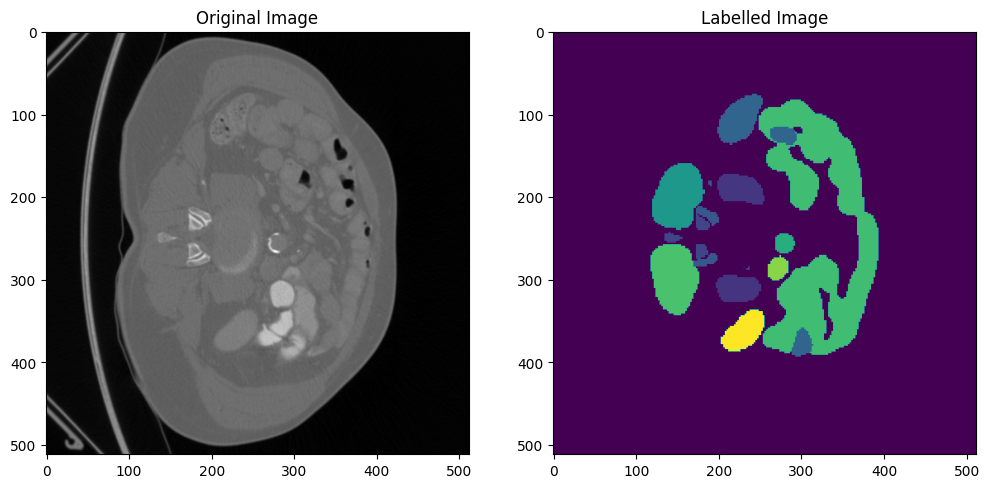

In [63]:
def label_to_image(label):
    return label.to_numpy().reshape(512, 512)

test = labels.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(data_train[0], cmap='gray')
axs[0].set_title('Original Image')

# Plot the label image
axs[1].imshow(label_to_image(test))
axs[1].set_title('Labelled Image')

plt.show()

### 2. Pre-Processing Functions

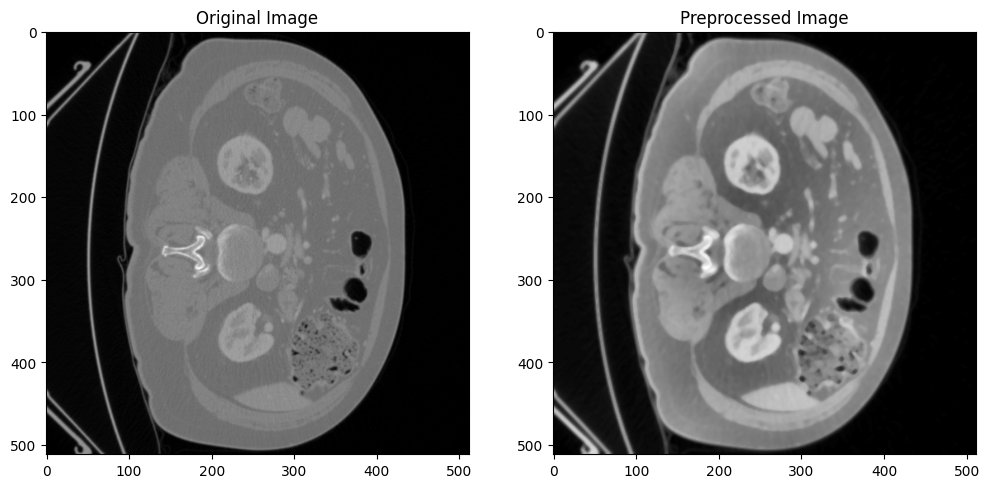

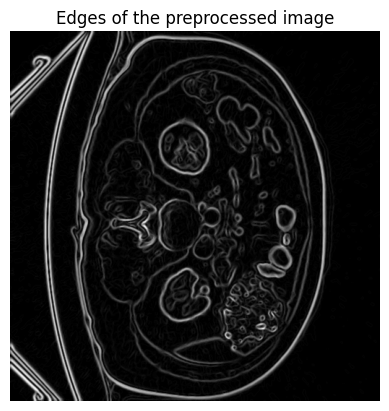

In [57]:


def preprocess_image(image):
    # Convert to float
    image = img_as_float(image)
    # Apply Gaussian filter for smoothing
    smoothed = gaussian(image, sigma=1)
    # Enhance contrast using adaptive histogram equalization
    equalized = exposure.equalize_adapthist(smoothed)
    # Normalize the intensity values
    normalized = (equalized - np.min(equalized)) / (np.max(equalized) - np.min(equalized))
    # Apply median filter to remove noise
    denoised = ndi.median_filter(normalized, size=5)
    return denoised

def get_edges(image):
    edges = sobel(image)
    edges_int = (edges * 255).astype(np.uint8)
    return edges_int

# Test preprocessing on one image
image = data_train[1]
preprocessed_image = preprocess_image(image)

# Visualize original and preprocessed image
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image, cmap='gray')
axs[1].set_title('Preprocessed Image')
plt.show()

edges = get_edges(preprocessed_image)

plt.imshow(edges, cmap='gray')
plt.title('Edges of the preprocessed image')
plt.axis('off')
plt.show()

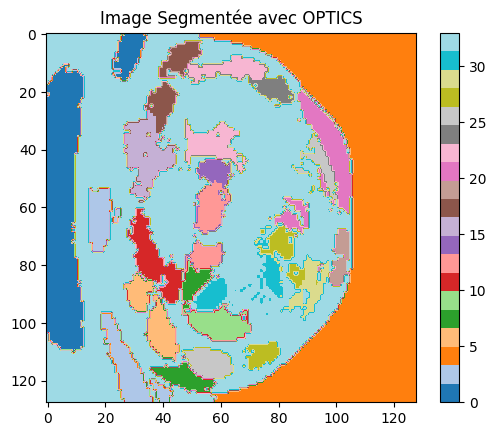

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

from scipy.ndimage import zoom

# Preprocess the image
image = data_train[0]  # Replace with your image
preprocessed_image = preprocess_image(image)

scale_factor = 0.25  # Réduction par 2
small_image = zoom(preprocessed_image, scale_factor, order=1)

# Nouvelles dimensions
height, width = small_image.shape

# Coordonnées spatiales pour la nouvelle taille
X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

# Mettre à jour les intensités et combiner les caractéristiques
pixel_values = small_image.flatten()
features = np.stack((pixel_values, X, Y), axis=-1)

# Normalize all features to have mean 0 and std 1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Étape 3 : Appliquer OPTICS
# OPTICS avec métrique Euclidienne
clustering = OPTICS(min_samples=50, xi=0.0006, min_cluster_size=0.005)
clustering.fit(features_scaled)

# Récupérer les labels des clusters
labels = clustering.labels_

# Étape 4 : Reconstruire l'image segmentée
# Créer une image où chaque pixel a la couleur de son cluster
segmented_image = labels.reshape(height, width)

# Remplacer -1 (bruit) par une couleur différente (par exemple, -1 → max label + 1)
unique_labels = np.unique(labels)
max_label = max(unique_labels)
segmented_image[segmented_image == -1] = max_label + 1

# Afficher le résultat
plt.imshow(segmented_image, cmap="tab20")
plt.title("Image Segmentée avec OPTICS")
plt.colorbar()
plt.show()

---
## K-Means Segmentation

In [41]:


# Define the range of k values
k_values = [20, 30, 40, 50]

# Preprocess the image
image = data_train[0]  # Replace with your image
preprocessed_image = preprocess_image(image)

# Get image dimensions
height, width = preprocessed_image.shape

# Flatten intensity values
pixel_values = preprocessed_image.flatten()

# Generate spatial coordinates
X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

# Combine features: intensity + spatial coordinates
features = np.stack((pixel_values, X, Y), axis=-1)

# Normalize all features to have mean 0 and std 1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Plot the results for each k value
fig, axs = plt.subplots(1, len(k_values), figsize=(18, 6))
fig.suptitle('KMeans Segmentation with Different k Values', fontsize=16)

for i, k in enumerate(k_values):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(features_scaled)
    cluster_labels = kmeans.labels_

    # Reshape labels back to the image shape
    segmented_image = cluster_labels.reshape(height, width)

    # Visualize the segmented image
    axs[i].imshow(segmented_image, cmap='nipy_spectral')
    axs[i].set_title(f'k={k}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

python(14714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled./opt/anaconda3/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded atthe same time. Both libraries are known to be incompatible and thiscan cause random crashes or deadlocks on Linux when loaded in thesame Python program.Using threadpoolctl may cause crashes or deadlocks. For moreinformation and possible workarounds, please see    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md  warnings.warn(msg, RuntimeWarning)KeyboardInterrupt

#### TODO
- Trouver les meilleurs paramètres pour le clustering
- Ré-unifier les blocs voisins de même intensité

---
## Mean Shift Segmentation

Prend trop de temps si on ne réduit pas les données

In [106]:
""" # %%
def meanshift_segmentation(image):
    # Flatten the image
    pixels = image.flatten()
    # Include spatial coordinates
    X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    features = np.stack((pixels, X.flatten(), Y.flatten()), axis=-1)
    # Apply Mean Shift clustering
    meanshift = MeanShift()
    meanshift.fit(features)
    clustered = meanshift.labels_.reshape(image.shape)
    return clustered

# Apply Mean Shift segmentation (Note: This is computationally intensive)
meanshift_labels = meanshift_segmentation(preprocessed_image)

# Visualize segmentation
plt.figure(figsize=(6, 6))
plt.imshow(meanshift_labels, cmap='nipy_spectral')
plt.title('Mean Shift Clustering Segmentation')
plt.show() """
None

---
## Sobel Filter and Watershed Algorithm

(PAS MACHINE LEARNING)

**Sobel Filter doc:**

[LINK](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html)

**Convolve doc:**

[LINK](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve)

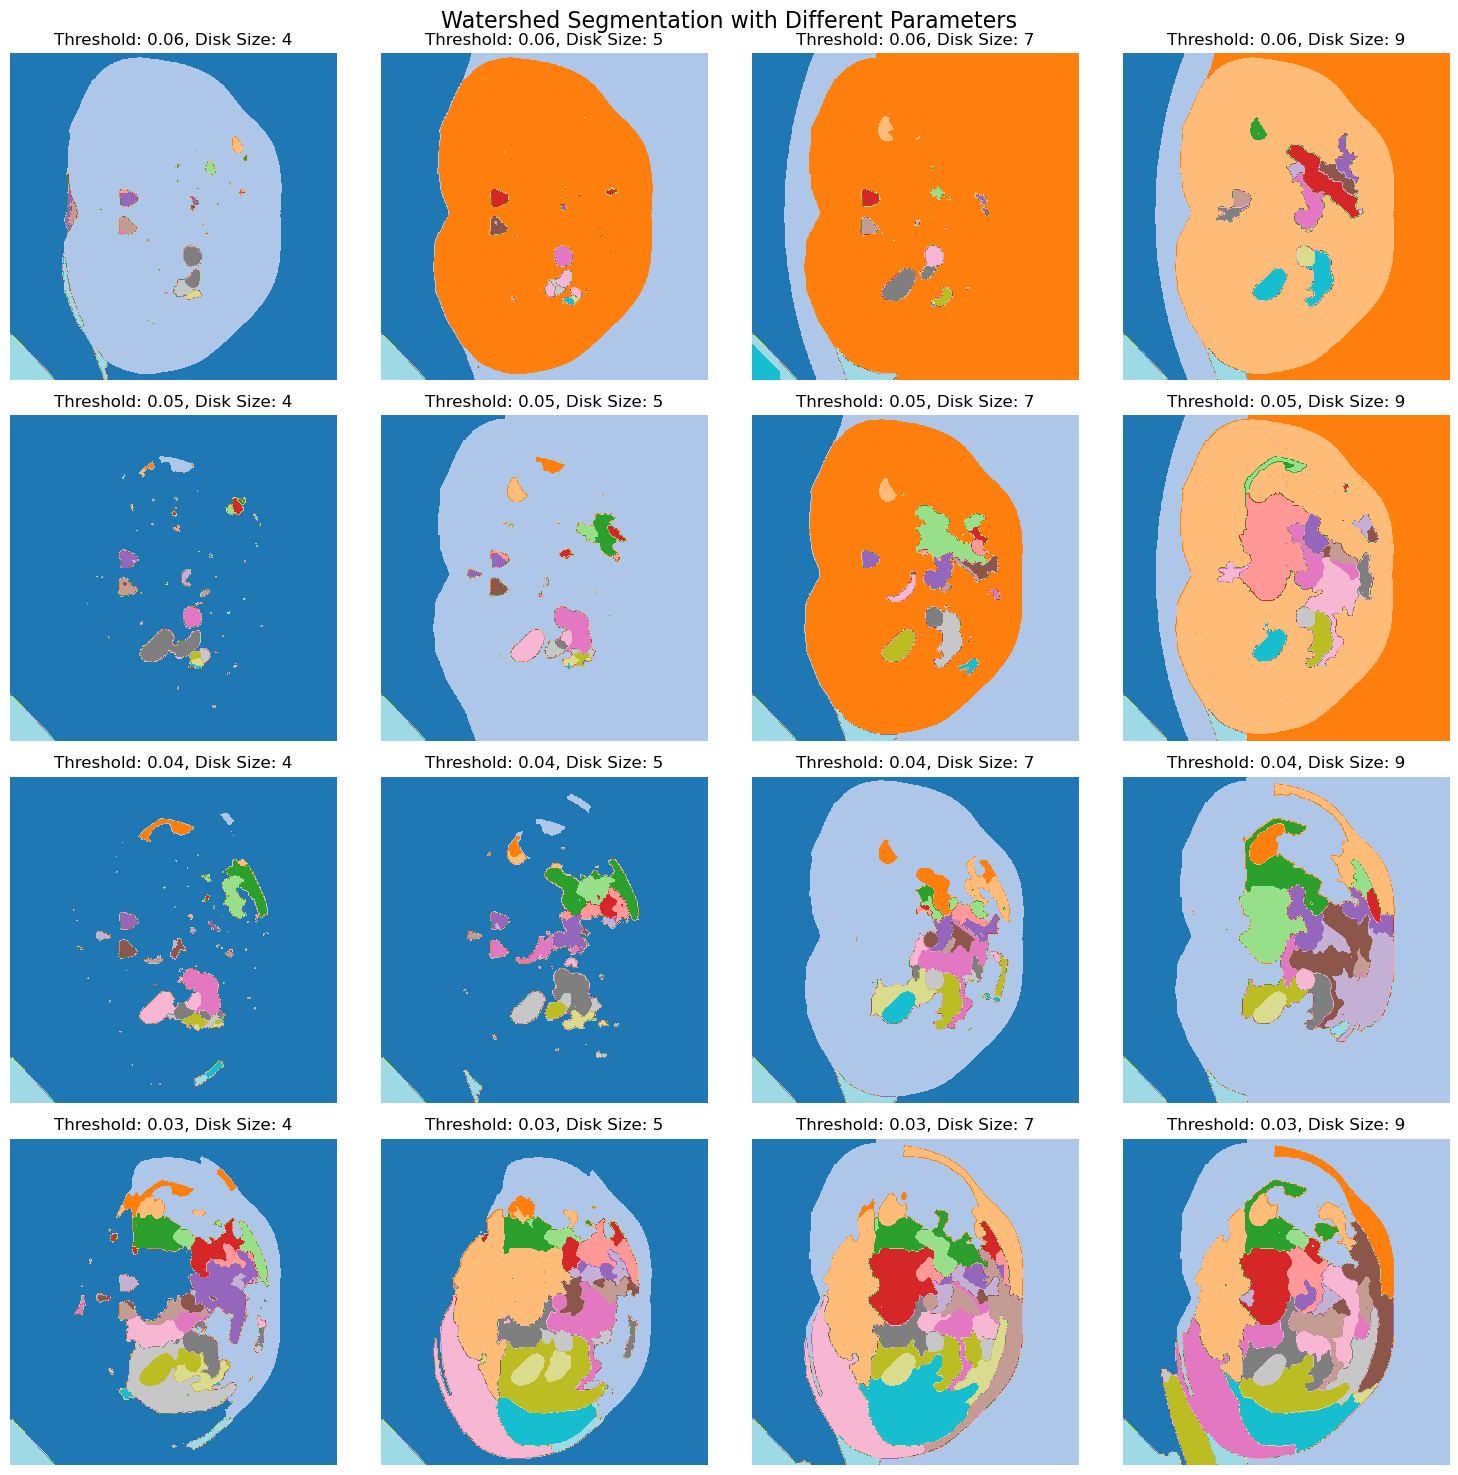

In [ ]:

# Define the parameter grid
param_grid = {
    'threshold': [0.06, 0.05, 0.04, 0.03],
    'disk_size': [4, 5, 7, 9]
}

# Create a grid of parameters
grid = ParameterGrid(param_grid)

# Function to apply watershed with given parameters
def apply_watershed(image, threshold, disk_size):
    params = (threshold, disk_size)
    edges = sobel(image)
    edges_int = (edges * 255).astype(np.uint8)
    markers = rank.gradient(edges_int, disk(disk_size)) < threshold * 255
    markers = ndi.label(markers)[0]
    segmentation = watershed(edges, markers)
    return segmentation, markers, edges

# Plot results for each parameter combination
fig, axs = plt.subplots(len(param_grid['threshold']), len(param_grid['disk_size']), figsize=(15, 15))
fig.suptitle('Watershed Segmentation with Different Parameters', fontsize=16)

for i, threshold in enumerate(param_grid['threshold']):
    for j, disk_size in enumerate(param_grid['disk_size']):
        segmentation, markers, edges = apply_watershed(preprocessed_image, threshold, disk_size)
        axs[i, j].imshow(
            segmentation, # OR markers OR edges
            cmap='tab20'
        )
        axs[i, j].set_title(f'Threshold: {threshold}, Disk Size: {disk_size}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

---
## LCM-Based Segmentation Method

https://www.nature.com/articles/s41598-018-31333-5